# Necassary Imports

In [1]:
# Imports
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
#import inflect
#from num2words import num2words
from nltk.corpus import stopwords
from collections import Counter

import sklearn

from gensim.models import Word2Vec

from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
import nltk 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Necassary preprocessing steps

In [2]:
# Import data
df = pd.read_csv('us_equities_news_dataset.csv')

In [3]:
# Filter out Nvidia articles
nvidia_df = df[df['title'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['content'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['ticker'].str.contains('NVIDIA|NVDA', case=False, na=False)]

In [4]:
print(len(nvidia_df))

3464


In [5]:
#Pre processing steps
def preprocess_text_iteration1(text):
    text = text.strip()
    # Replace URLs with an empty string
    re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    words = word_tokenize(text.lower())
    #check if the word is alpha numeric
    alpha_words = [word for word in words if word.isalpha()]
    #remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    #stop words removal
    stop_words = set(stopwords.words('english'))
    stop_words_removed = [word for word in numbers_words if not word in stop_words]
    #add lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_words_removed]

    return lemmatized_words

# apply preprocessing

# include title in "content"
nvidia_df['content'] = nvidia_df['title'] + ' ' + nvidia_df['content']
nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)

## Remove words that appear too frequently or too infrequently
# Count the frequency of each word
all_words = [word for content in nvidia_df['content'] for word in content]
word_freq = Counter(all_words)

# Define thresholds (play around with these)
min_freq = 5
max_freq = 0.7 * len(nvidia_df)

# Filter words based on frequency
filtered_words = {word for word, freq in word_freq.items() if min_freq <= freq <= max_freq}

# Update the DataFrame with filtered words
def filter_content(content):
    return [word for word in content if word in filtered_words]


nvidia_df['content'] = nvidia_df['content'].apply(filter_content)


C:\Users\bvits\AppData\Local\Temp\ipykernel_13832\2458803087.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['title'] + ' ' + nvidia_df['content']
C:\Users\bvits\AppData\Local\Temp\ipykernel_13832\2458803087.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)
C:\Users\bvits\AppData\Local\Temp\ipykernel_13832\2458803087.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [6]:
#create a document term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(nvidia_df['content'].apply(lambda x: ' '.join(x)))
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## LDA

[['point', 'percent', 'close', 'trading', 'fell', 'rose', 'dow', 'oil', 'future', 'friday'], ['current', 'portfolio', 'past', 'performance', 'today', 'security', 'value', 'firm', 'return', 'eps'], ['fiscal', 'reported', 'cent', 'positive', 'solution', 'cloud', 'demand', 'margin', 'corporation', 'gaap'], ['etf', 'fund', 'traded', 'past', 'read', 'holding', 'volume', 'exposure', 'since', 'global'], ['driving', 'car', 'google', 'self', 'ai', 'vehicle', 'amazon', 'facebook', 'autonomous', 'device']]
Topic 0: point percent close trading fell rose dow oil future friday
Topic 1: current portfolio past performance today security value firm return eps
Topic 2: fiscal reported cent positive solution cloud demand margin corporation gaap
Topic 3: etf fund traded past read holding volume exposure since global
Topic 4: driving car google self ai vehicle amazon facebook autonomous device
[[9.97010036e-01 7.46315347e-04 7.47834787e-04 7.55076533e-04
  7.40737759e-04]
 [7.83877570e-01 6.62076775e-02 9.

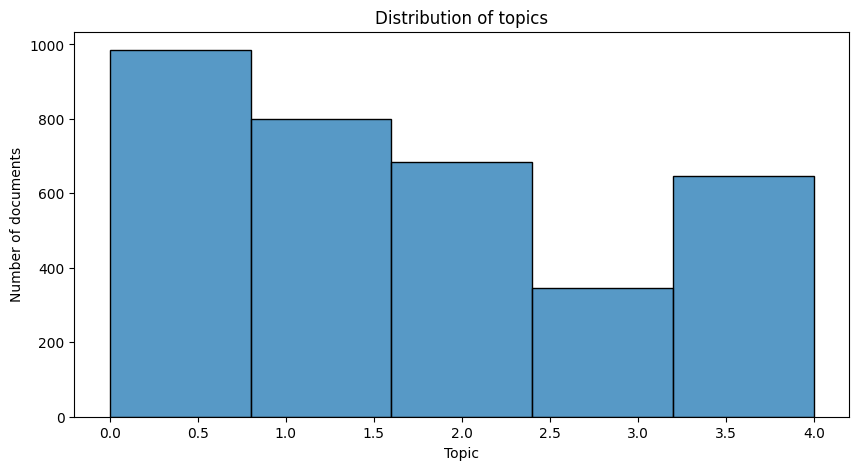

In [7]:
# train LDAModel
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0) #once I can run zeroth it, change n_components to something else
lda.fit(X)

# get topics
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

topics = get_topics(lda, vectorizer, 10)
print(topics)
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, ' '.join(topic)))


# get topic distribution for each document
topic_dist = lda.transform(X)
print(topic_dist)

# plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.histplot(topic_dist.argmax(axis=1), bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics')
plt.show()



In [8]:
# create a cluster plot for the topics

#if we have more time we look this because it is a cool plot (we don't fully understand it because copilot made it)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embedding = tsne.fit_transform(topic_dist)
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=topic_dist.argmax(axis=1), palette='tab10')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.title('t-SNE plot of topics')
# plt.show()

## FLSA-W

In [9]:
# FuzzyTM FLSA-W
from FuzzyTM import FLSA_W

# Coherence and Diversity



In [10]:


# create a FLSA-W model (based on the previous iteration, we can conclude that 5 topics is best)
# We continue with 5 topics since we notice the coherence is highest, and the diversity is also good (but not the highest)
flsaW = FLSA_W(
input_file = nvidia_df['content'].to_list(),
num_topics=5,
num_words=10,
)

In [11]:
flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL
print(flsaW.show_topics())


[(0, '0.0033*"compared" + 0.0033*"adoption" + 0.0032*"gaming" + 0.0031*"basis" + 0.0031*"computing" + 0.0029*"ago" + 0.0028*"segment" + 0.0028*"believe" + 0.0027*"significant" + 0.0027*"fourth"'), (1, '0.0182*"generation" + 0.0161*"margin" + 0.0156*"expect" + 0.0144*"executive" + 0.0143*"gross" + 0.0142*"know" + 0.0136*"half" + 0.0135*"think" + 0.013*"chief" + 0.013*"server"'), (2, '0.0017*"corporation" + 0.0016*"investing" + 0.0015*"corp" + 0.0015*"gained" + 0.0015*"com" + 0.0014*"surged" + 0.0014*"released" + 0.0014*"point" + 0.0013*"added" + 0.0013*"boost"'), (3, '0.0006*"inbox" + 0.0005*"previously" + 0.0005*"phlx" + 0.0005*"amat" + 0.0005*"ratio" + 0.0005*"contract" + 0.0005*"ltd" + 0.0005*"advancing" + 0.0005*"bac" + 0.0005*"gmt"'), (4, '0.0004*"premarket" + 0.0003*"unveils" + 0.0003*"smh" + 0.0003*"uncover" + 0.0003*"conclusively" + 0.0003*"esp" + 0.0003*"avoided" + 0.0003*"soxx" + 0.0003*"strategiesit" + 0.0003*"delve"')]


## Compute Diversity, Coherence, Interpretability for FLSA-W and LDA

In [ ]:
for topic in flsaW.show_topics(representation='words'):
    print(topic)


print(flsaW.get_coherence_score()) # ask if this has to be high
print(flsaW.get_diversity_score()) # ask if this has to be high
print(flsaW.get_interpretability_score()) # ask if this has to be high




['compared', 'adoption', 'gaming', 'basis', 'computing', 'ago', 'segment', 'believe', 'significant', 'fourth']
['generation', 'margin', 'expect', 'executive', 'gross', 'know', 'half', 'think', 'chief', 'server']
['corporation', 'investing', 'corp', 'gained', 'com', 'surged', 'released', 'point', 'added', 'boost']
['inbox', 'previously', 'phlx', 'amat', 'ratio', 'contract', 'ltd', 'advancing', 'bac', 'gmt']
['premarket', 'unveils', 'smh', 'uncover', 'conclusively', 'esp', 'avoided', 'soxx', 'strategiesit', 'delve']


In [ ]:
#coherence for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
coherence_lda = flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
topics)

print(coherence_lda)

In [ ]:
#diversity for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
diversity_lda = flsaW.get_diversity_score(topics)
print(diversity_lda)

In [ ]:
#lda interpretability
interpretability_lda = diversity_lda * coherence_lda
print(interpretability_lda)

## Elbow plots (FLSA-W and LDA)

In [ ]:
#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    #train model
    print(n_topics)
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get coherence
    coherence = flsaW_elbow.get_coherence_score()
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W iteration 2')
plt.show()


In [ ]:
#elbow plot for diversity

#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get diversity
    diversity = flsaW_elbow.get_diversity_score()
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W iteration 2')
plt.show()


In [ ]:
#elbow plot for interpretability
range_n_topics = range(1, 11)
#elbow plot for FLSA-W
interpretabilities = []
for i in range_n_topics:
    print(i)
    interpretability =  coherences[i-1]*diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W iteration 2')
plt.show()

## LDA

In [ ]:
#elbow plot for coherence

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get coherence
    topics = get_topics(lda, vectorizer, 10)

    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    topics)
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics LDA iteration 2')
plt.show()


In [ ]:
#elbow plot for diversity

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get diversity
    topics = get_topics(lda, vectorizer, 10)

    diversity = flsaW.get_diversity_score(
    
    topics)
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics LDA iteration 2')
plt.show()

In [ ]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics LDA iteration 2')
plt.show()

They remain stable. It would be interesting to write a discussion. (there is little variation why?)

## Bert Topic

In [ ]:
from bertopic import BERTopic
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0)
docs = [' '.join(doc) for doc in nvidia_df['content']]
# Create the model (uses DistilBERT by default)
bert_topic = BERTopic(umap_model=umap_model)
# Train the model and transform your data into topics
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
bert_topic.get_topics()



In [ ]:
print(topic_matrix)

In [ ]:
bert_topic.visualize_heatmap(n_clusters=15)

In [ ]:
topic_matrix.head(10)

In [ ]:
# print the name of the topic matrix and the representative docs using for loop
for i in range(0, 11):
    print(topic_matrix['Name'][i])
    print(topic_matrix['Representative_Docs'][i])
    print('')

In [ ]:
#create a list of the first 10 representative docs
rep_docs = topic_matrix['Representation'][1:10].to_list()
print(rep_docs)




In [ ]:
#bert coherence --> just say we tried, in the end it doesn't matter I tried hard and got so far 
print(
flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
rep_docs[0:4])
)



In [ ]:
#bert diversity
print(flsaW.get_diversity_score(rep_docs[0:4]))

In [ ]:
#elbow plot for coherence

#elbow plot for Bert
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #get coherence
    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    rep_docs[0:n_topics])
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics Bert iteration 2')
plt.show()


topic

In [ ]:
#elbow plot for diversity

#elbow plot for Bert
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #get diversity
    diversity = flsaW.get_diversity_score(rep_docs[0:n_topics])
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics Bert iteration 2')
plt.show()

In [ ]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics Bert iteration 2')
plt.show()